# Gru GAN 1024

## Import

In [1]:
import argparse
import os
import sys
import numpy as np
import math
import pickle
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import random
from cv2 import VideoWriter, VideoWriter_fourcc, imread

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

import warnings

## Hyperparameters

In [2]:
n_epochs = 100 # type=int, "number of epochs of training"
batch_size = 1 # type=int, "size of the batches"

lr = 0.002 # type=float "adam: learning rate"
b1 = 0.9 # type=float "adam: decay of first order momentum of gradient"
b2 = 0.999 # type=float "adam: decay of first order momentum of gradient"

num_gpu = 2 
cuda = torch.cuda.is_available()

latent_dim = 4 # type=int "dimensionality of the latent space"
img_size = 1024 # type=int "size of each image dimension"
channels = 1 # type=int "number of image channels"
sample_interval = 10000 # int "interval betwen image samples"

FLenTar = 100

teacher_forcing_ratio = 0.7

dataset_dir = r"C:\Users/Leo's PC/Documents/SSTP Tests/SSTP/GruGan/test_frames"

torch.cuda.set_device(0)

critical_iter = 5

## Datasets

In [3]:
class Dataset(Dataset):

    def __init__(self, file_dir, transform=None):

        self.dir = file_dir
        self.transform = transform
        self.diction = {}
        
        idx = 0
        for filename in os.listdir(self.dir):
            if filename.endswith('jpg'):
                self.diction[idx] = filename
                idx += 1
                        
    def __len__(self):
        return len(self.diction) - 1

    
    def __getitem__(self, idx):
        x, y = self.diction[idx], self.diction[idx + 1]
        directory_x, directory_y = self.dir + "\\" + str(x), self.dir + "\\" + str(y)
        x, y = cv.imread(directory_x), cv.imread(directory_y)
        if self.transform:
            x, y = self.transform(x), self.transform(y)
        return [x / 255, y / 255]

    
def HWC2CHW(x):
    return np.array(x).transpose(2, 0, 1)


dataset = Dataset(file_dir=dataset_dir, transform=HWC2CHW)

## Dataloaders

In [4]:
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)

## Model classes

In [5]:
from ModelZoo import TemporalDiscriminator, StyleGanGenerator, StyleGanDiscriminator

In [6]:
class LengthScheduler():
    def __init__(self, target_seq_len=100):
        self.target_len_final = target_seq_len
        self.current_seq_len_target = 2
        self.total_call_count = 0
        self.running_count = 0
        self.trained_count = 0
        self.loss_hist = np.array([])
    
    
    def adjust_target_len(self, manual=True):   
        
        def read_txt(txt=r"C:/Users/Leo's PC/Documents/SSTP Tests/SSTP/length.txt"):
            with open(txt, "r") as f:
                return int(f.read())

        if manual == True:
            self.current_seq_len_target = read_txt()

        else:

            self.dy = np.diff(self.loss_hist)

            try:
                self.running_dy = self.running_dy * 0.9 + self.dy[-1] * (1 - 0.9)
            except:
                self.running_dy = -1

            if self.running_dy > -0.00005:
                self.current_seq_len_target += 1
                print('training length changed to', self.current_seq_len_target)
                    
    
    def approve(self, loss, current_seq_len):
        
        def return_true(update=True):
            self.total_call_count += 1
            self.running_count = 0
            self.trained_count += 1
            
            self.loss_hist = np.append(self.loss_hist, loss)
            
            if update: self.adjust_target_len()
            
            return True
        
        def return_false():
            self.total_call_count += 1
            self.running_count += 1
            
            return False     
        
        #############################
        '''
        if self.total_call_count < 200:
            # for the first 200 inputs, always return True
            return return_true(update=False)
        else:
        '''
        return return_true() if self.running_count >= self.current_seq_len_target else return_false()
        
        
    def reset(self):
        self.total_call_count = 0
        self.running_count = 0
        self.trained_count = 0
        
        
def log_stats(log, iteration, Gloss, Gloss_gt, Gloss_ad, Dloss, Dloss_fake, Dloss_real, length):
    log['iteration'].append(iteration)
    log['Gloss'].append(Gloss.detach())
    log['Gloss_gt'].append(Gloss_gt.detach())
    log['Gloss_ad'].append(Gloss_ad.detach())
    log['Dloss'].append(Dloss.detach())
    log['Dloss_fake'].append(Dloss_fake.detach())
    log['Dloss_real'].append(Dloss_real.detach())
    log['length'].append(length)
    
    return log
    
    
def graph_stats(log):
    #plt.clf()
    figure = plt.figure()
    matplotlib.rcParams["figure.dpi"] = 130

    plt.grid(axis='y')
    
    plt.plot(np.arange(0, len(log['Gloss'])), log['Gloss'], label="G Loss")
    plt.plot(np.arange(0, len(log['Dloss'])), log['Dloss'], label="D Loss")
    
    plt.ylabel('Loss')
    plt.xlabel('Trained Iterations')

    #plt.xticks(ticks=len(log['Gloss']), labels=np.arange(0, len(log['Gloss']), 1))
    plt.legend(loc='upper left')
    
    plt.show()
    plt.close()

In [7]:
def numpy2video(
    arr: np.ndarray, # array of cv2 images
    mp4_path="np_out.mp4", # path to output mp4 video
    fps=30, # framerate
    scale=True, # whether to scale from 0-1 to 0-255
    target_dim=(1920,1080), # tuple of (width, height) for the target video size
    is_color=True # whether the input images are color
    ):
  
  """
  Creates video from aray of cv2-format images
  """
  
  assert mp4_path.endswith('.mp4')
  
  frameSize= (target_dim[0], target_dim[1])
  out = VideoWriter(
      mp4_path,VideoWriter_fourcc(*'MP4V'), fps, frameSize, is_color)
    
  if scale:
    for img in arr:
      img = np.multiply(img, 255).astype("uint8")
      img = cv.resize(img, target_dim, interpolation=cv.INTER_CUBIC)
      out.write(img)
  else:
    for img in arr:
      img = img.astype("uint8")
      img = cv.resize(img, target_dim, interpolation=cv.INTER_CUBIC)
      out.write(img)

  out.release()

## Loss, Optimizer, Training setup

In [8]:
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss()
MSE_loss = torch.nn.MSELoss()


# Initialize generator and discriminator
G = StyleGanGenerator()
Dt = TemporalDiscriminator()
Ds = StyleGanDiscriminator()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

G.cuda()
Dt.cuda()
Ds.cuda()
adversarial_loss.cuda()
MSE_loss.cuda()


#G = torch.nn.DataParallel(G)
#D = torch.nn.DataParallel(D)


optimizer_G = torch.optim.Adam(G.parameters(), lr=0.001, betas=(b1, b2))
optimizer_Dt = torch.optim.Adam(Dt.parameters(), lr=0.001, betas=(b1, b2))
optimizer_Ds = torch.optim.Adam(Ds.parameters(), lr=0.001, betas=(b1, b2))

scaler_G = GradScaler()
scaler_Dt = GradScaler()
scaler_Ds = GradScaler()

Tensor = torch.cuda.FloatTensor
scheduler = LengthScheduler()

training_log = {
    'iteration':[],
    'Gloss':[],
    'Gloss_gt':[],
    'Gloss_ad':[],
    'Dloss':[],
    'Dloss_fake':[],
    'Dloss_real':[],
    'length':[]
}

In [9]:
'''
for p in G.module.StyleGan.parameters():
    p.requires_grad = True
    
for p in Ds.module.StyleGan.parameters():
    p.requires_grad = True
    
'''
    
'''
for p in D.module.parameters():
    print(p.requires_grad)
'''

for p in G.parameters():
    # assert p.requires_grad == True
    p.requires_grad = True
    
for p in Ds.parameters():
    # assert p.requires_grad == True
    p.requires_grad = True
    
for p in Dt.parameters():
    # assert p.requires_grad == True
    p.requires_grad = True

## Training

The Generator takes an input frame x, outputs a fake frame y_hat. If we calculate the loss and back_prop now, we are training a Generator that can predict the next frame. If a sequence of mutiple fake frames is desired during inference, we then feed the Generator y_hat as the input and get the next frame. However, here's a problem: during training, the model only learns how to produce a fake frame based on a real frame. If we want to countinuously feed the model hundreds of  fake frames, the quality of the output will deteriorate quickly.

Therefore, we train the model in a way that it's loss is judged based on the whole sequence, not just the next frame. In a sense, this trains the model in a setup that is closer to its use-case senerio. However, keep in mind that the video is still generated by passing in fake(t-1) to get fake(t), in a loop.

We propose a length scheduler that automatically determines the length of the output sequence based on which the generator will be judged. The generator will start with learning how to predict the next frame. When it gets good at it, it will learn to generate 2 frames, untill the target value is hit.

### Training with Scheduler

### Countinueous Training

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


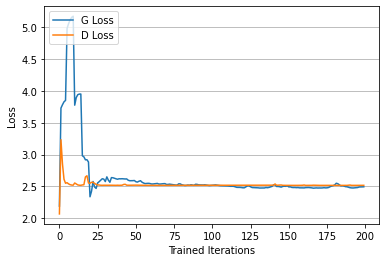

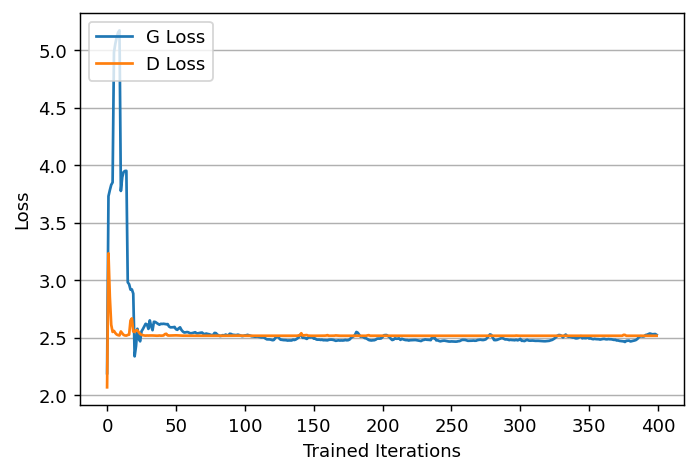

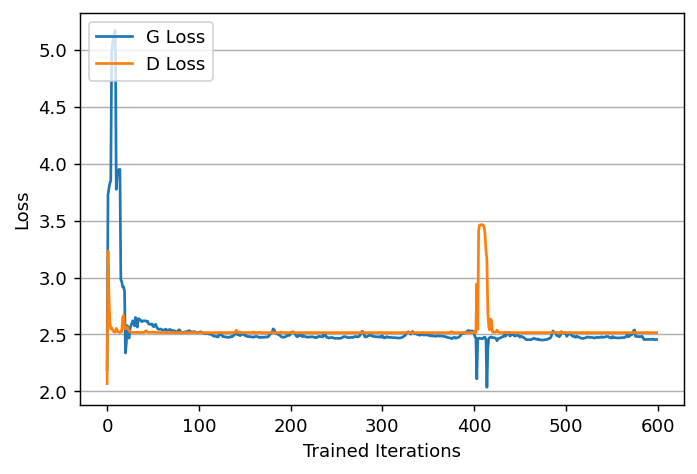

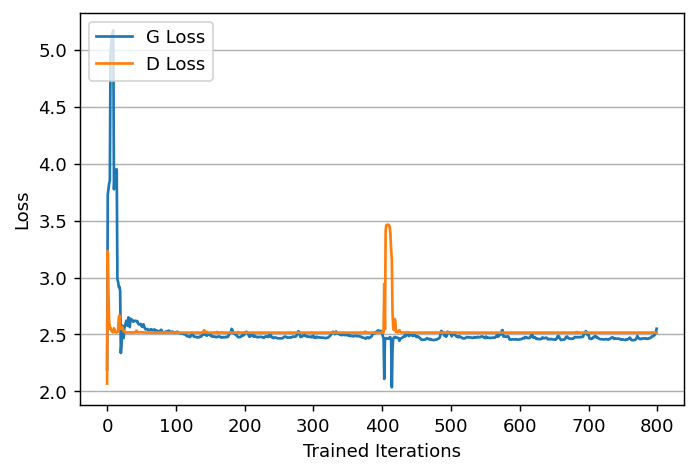

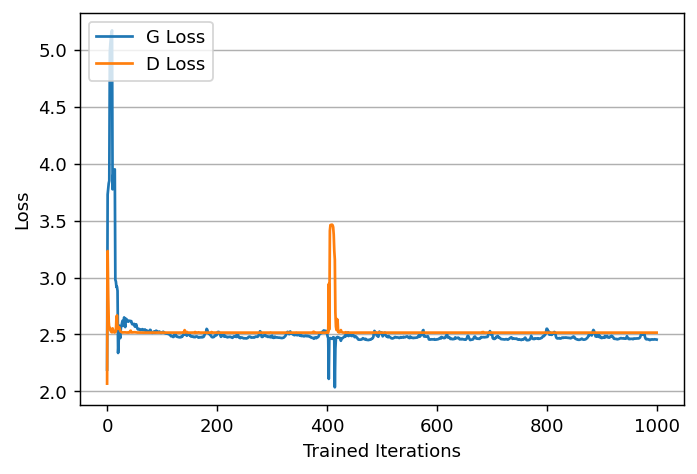

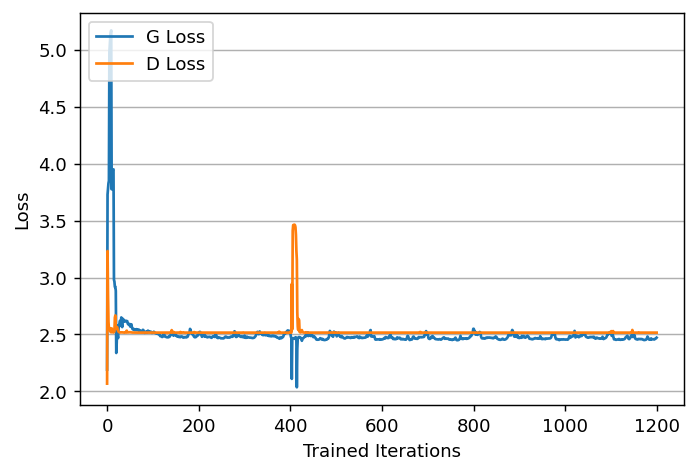

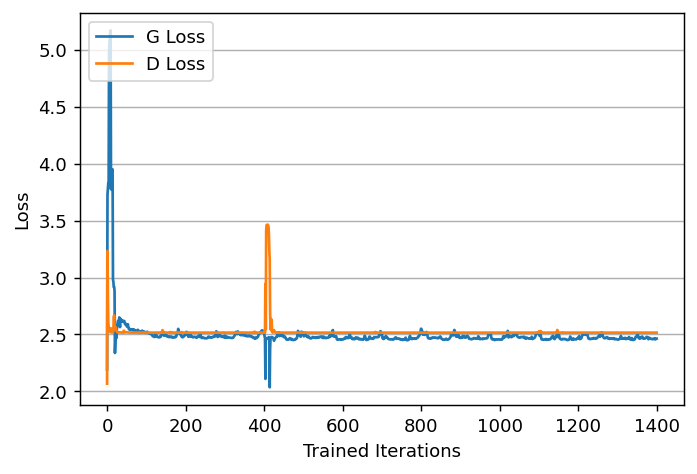

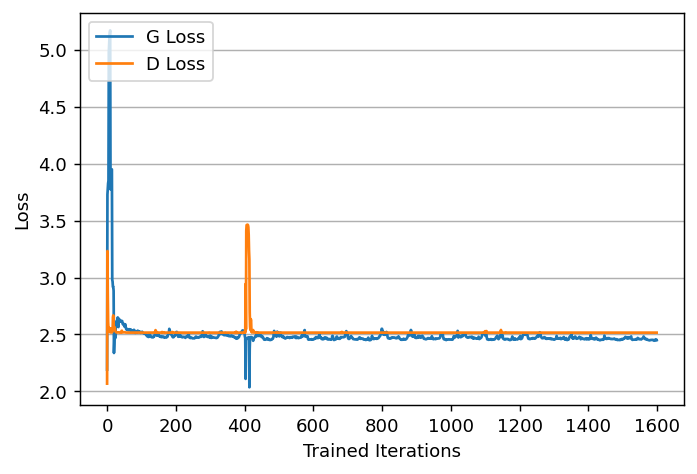

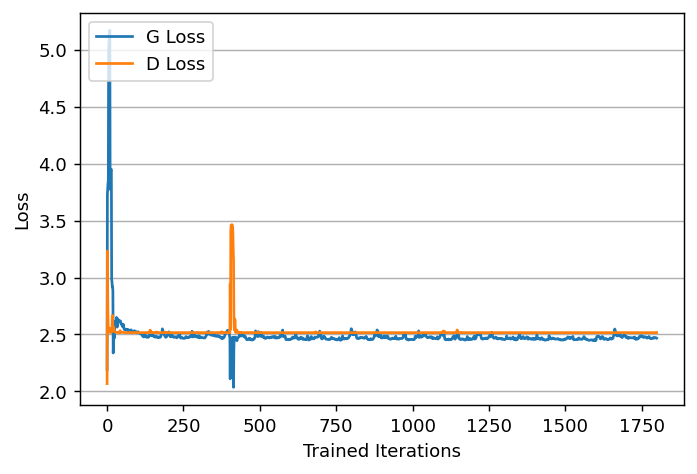

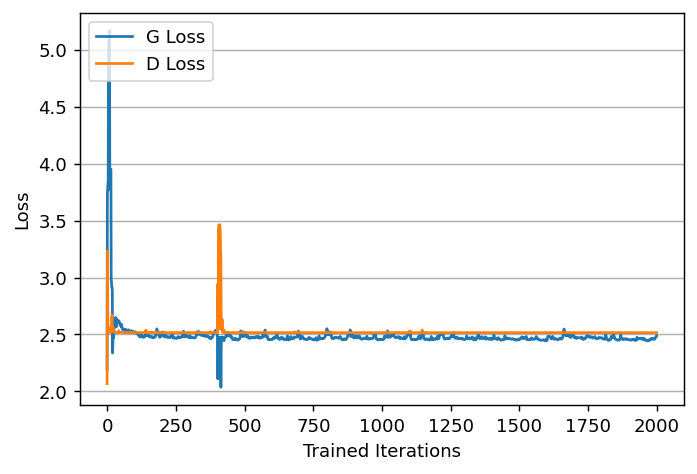

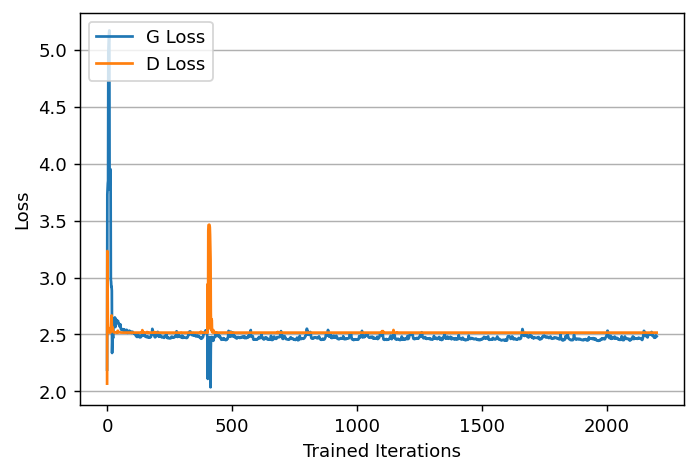

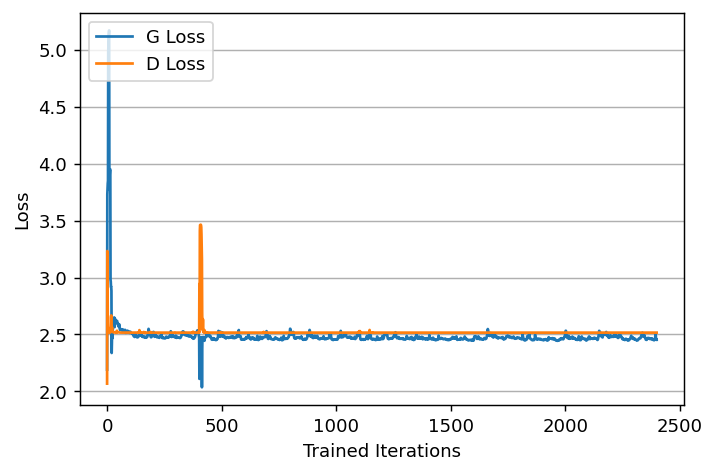

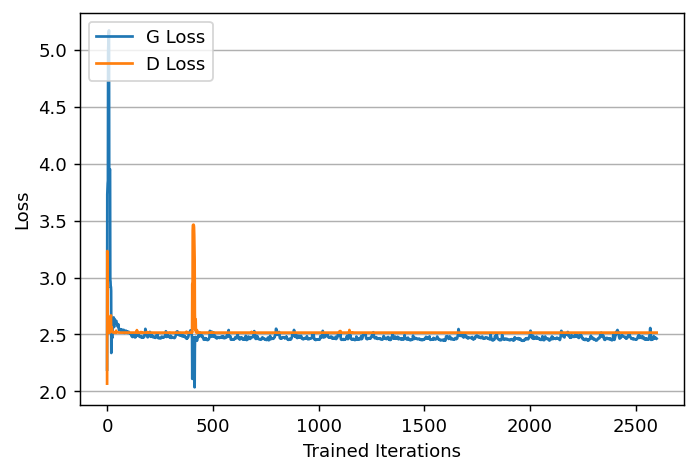

KeyboardInterrupt: 

In [10]:
x_list = []
y_list = []
y_hat_list = []
y_hat_temporal_list = []
# rating = 0
g_loss = 0
d_loss = 0

# torch.autograd.set_detect_anomaly(False) #for debugging
warnings.filterwarnings("ignore", category=UserWarning)

#scheduler.reset()

# Gh = torch.Tensor(np.random.randn(3 * num_gpu, int(batch_size / num_gpu), 512)).cuda() #Generator hidden state initialization (num_layers, batchsize, inp.shape)
# Dh = torch.Tensor(np.random.randn(3 * num_gpu, int(batch_size / num_gpu), 512)).cuda() #Discriminator hidden state initialization (num_layers, batchsize, inp.shape)

Gh = torch.Tensor(np.random.randn(3, 1, 512)).cuda() #Generator hidden state initialization (num_layers, batchsize, inp.shape)
Dh = torch.Tensor(np.random.randn(3, 1, 512)).cuda() #Discriminator hidden state initialization (num_layers, batchsize, inp.shape)

###################
# START OF TRAINING
###################

for epoch in range(20):
    
    for i, x in enumerate(loader):

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        x, y = Variable(x[0].type(Tensor)).cuda().to(device), Variable(x[1].type(Tensor)).cuda().to(device)
        x_list.append(x.detach())
        y_list.append(y.detach())

        if use_teacher_forcing or len(y_hat_list) is 0:
            y_hat, Gh = G(x, Gh) #Generator Forward with true frame as input

        else:
            y_hat, Gh = G(y_hat.detach(), Gh) #Generator Forward with fake frame as input

        y_hat_list.append(y_hat.detach())

        #Process y_hat_list for temporal Discriminator
        y_hat_temporal = (y_hat[0][0] + y_hat[0][1] + y_hat[0][2])/3
        y_hat_temporal = F.max_pool2d(y_hat_temporal.unsqueeze(0), kernel_size = [2, 2], stride=2, padding=0).unsqueeze(0)
        y_hat_temporal_list.append(y_hat_temporal.detach())

        with autocast():
            rating_t, Dh = Dt(Variable(Tensor(y_hat_temporal)), Dh) # get Temporal Discriminator rating on the fake

        rating_s = Ds(Variable(Tensor(y_hat)))

        ad_loss = adversarial_loss(rating_t, Variable(Tensor([[1]]))) * 0.3 + adversarial_loss(rating_s, Variable(Tensor([[1]]))) * 0.7
        gt_loss = MSE_loss(y_hat, y)
        g_loss += 0.7 * ad_loss + 0.3 * gt_loss #accumulate g_loss

        ## Evaluation and backprop
        if scheduler.approve(1, len(y_hat_list)): #returns True if it approves of evaluation

            ## ========================
            ## Train the Generator
            ## ========================
            
            if scheduler.trained_count % critical_iter == 0:
                
                g_loss.backward(retain_graph=False)
                optimizer_G.step()

                nn.init.xavier_uniform_(Gh) #clear G memory
                G.zero_grad() #reset G gradient

            ## ========================
            ## Train the Discriminator
            ## ========================
 
            ##----------------------------------
            ## Train the Spatial Discriminator
            ##----------------------------------

            nn.init.xavier_uniform_(Dh) #clear D memory
            optimizer_Dt.zero_grad() #reset D gradient
            real_loss = 0
            fake_loss = 0

            with autocast():

                ###TRAINING ON FAKE FRAMES###

                x_temporal = (x_list[0][0][0] + x_list[0][0][1] + x_list[0][0][2])/3
                x_temporal = F.max_pool2d(x_temporal.unsqueeze(0), kernel_size = [2, 2], stride=2, padding=0).unsqueeze(0)
                rating, Dh = Dt(x_temporal, Dh) #pass the first real frame thourgh D

                for y_hat_temporal in y_hat_temporal_list:
                    rating, Dh = Dt(y_hat_temporal, Dh)  # then pass in the subsequent fake frames
                    fake_loss += adversarial_loss(rating, Variable(Tensor([[0]])))

                nn.init.xavier_uniform_(Dh) #clear D memory

                ###TRAINING ON REAL FRAMES###
                
                x_temporal = (x_list[0][0][0] + x_list[0][0][1] + x_list[0][0][2])/3
                x_temporal = F.max_pool2d(x_temporal.unsqueeze(0), kernel_size = [2, 2], stride=2, padding=0).unsqueeze(0)
                rating, Dh = Dt(x_temporal, Dh) #pass the first real frame thourgh D

                for y in y_list:
                    y_temporal = (y[0][0] + y[0][1] + y[0][2])/3
                    y_temporal = F.max_pool2d(y_temporal.unsqueeze(0), kernel_size = [2, 2], stride=2, padding=0).unsqueeze(0)

                    rating, Dh = Dt(y_temporal, Dh)  # then pass in the subsequent real frames
                    real_loss += adversarial_loss(rating, Variable(Tensor([[1]])))

            d_loss = 0.5 * real_loss + 0.5 * fake_loss

            # backprop on D
            scaler_Dt.scale(d_loss).backward()
            scaler_Dt.step(optimizer_Dt) 
            scaler_Dt.update()

            ##----------------------------------
            ## Train the Spatial Discriminator
            ##----------------------------------

            optimizer_Ds.zero_grad() #reset D gradient
            real_loss = 0
            fake_loss = 0

            ###TRAINING ON FAKE FRAMES###

            rating = Ds(x_list[0]) #pass the first real frame thourgh D

            for y_hat in y_hat_list:
                rating = Ds(y_hat)  # then pass in the subsequent fake frames
                fake_loss += adversarial_loss(rating, Variable(Tensor([[0]])))

            ###TRAINING ON REAL FRAMES###

            rating = Ds(x_list[0]) #pass the first real frame thourgh D

            for y in y_list:
                rating = Ds(y)  # then pass in the subsequent real frames
                real_loss += adversarial_loss(rating, Variable(Tensor([[1]])))

            d_loss = 0.5 * real_loss + 0.5 * fake_loss

            # backprop on D
            d_loss.backward()
            optimizer_Ds.step()


            training_log = log_stats(training_log, iteration=i+1, Gloss=g_loss, Gloss_gt=gt_loss, Gloss_ad=ad_loss, Dloss=d_loss, Dloss_fake=fake_loss, Dloss_real=real_loss, 
                                     length=scheduler.current_seq_len_target)

            # print((np.array([i.cpu().numpy() for i in y_hat_temporal_list]).squeeze(1).transpose(0, 2, 3, 1)).shape)
            if i%100 - 1 == 0 and i != 1:
                numpy2video(np.array([i.cpu().numpy() for i in y_hat_list]).squeeze(1).transpose(0, 2, 3, 1), fps=5, mp4_path="out.mp4")
                numpy2video(np.array([i.cpu().numpy() for i in y_list]).squeeze(1).transpose(0, 2, 3, 1), fps=5, mp4_path="in.mp4")
                numpy2video(np.array([i.cpu().numpy() for i in y_hat_temporal_list]).squeeze(1).transpose(0, 2, 3, 1), fps=5, mp4_path="temporal.mp4", is_color=False)

            # reset for next interation
            y_hat_list = []
            y_hat_temporal_list = []
            y_list = []
            x_list = []
            g_loss = 0


        sys.stdout.write('[%d batches done] [%d batches trained] [Len_target=%d] G_Loss: %f D_Loss: %f\r' % (i+1, scheduler.trained_count, scheduler.current_seq_len_target, g_loss, d_loss))
        sys.stdout.flush()

        if i%1000 - 1 == 0 and i != 1:
            graph_stats(training_log)

In [ ]:
! dir

In [ ]:
with open('network-snapshot-000720.pkl', 'rb') as f:
    Dis = pickle.load(f)['D'].cuda() 
    
print(Dis(torch.Tensor(np.random.rand(1, 3, 256, 256)).cuda(), None))

### Visualize a Frame in Output

In [ ]:
print(len(y_hat_list))
plt.imshow((np.array(y_hat_list[4][0].cpu()).transpose(1, 2, 0)+1)/2)

In [11]:
Gh = torch.Tensor(np.random.randn(3, 1, 512)).cuda()

y_hat_list = []
y_list = []
x_list = []
        
for i, x in enumerate(loader):
    
    x, y = Variable(x[0].type(Tensor)).cuda().to(device), Variable(x[1].type(Tensor)).cuda().to(device)
    # x, y = Variable(Tensor(np.random.randn(1, 3, 256, 256))).cuda().to(device), Variable(Tensor(np.random.randn(1, 3, 256, 256))).cuda().to(device)
    x_list.append(x)
    y_list.append(y.detach().cpu().numpy())
    
    y_hat, Gh = G(x, Gh)
    
    y_hat_list.append(y_hat.detach().cpu().numpy())
    
    if i == 10: break 

    
y_hat_list = np.asarray(y_hat_list).squeeze(1).transpose(0, 2, 3, 1)
y_list = np.asarray(y_list).squeeze(1).transpose(0, 2, 3, 1)

numpy2video(y_hat_list, fps=2, mp4_path="out_eval.mp4")
numpy2video(y_list, fps=2, mp4_path="in_eval.mp4")

In [ ]:
'''
checkpoint_file = open(r"C:/Users/Leo's PC/Documents/SSTP Tests/SSTP/GruGan/G.tar", 'wb')
torch.save({'model': G.state_dict()}, checkpoint_file)
checkpoint_file.close()

'''
checkpoint = torch.load(open("C:/Users/Leo's PC/Documents/SSTP Tests/SSTP/GruGan/G.tar", 'rb'))
G.load_state_dict(checkpoint['model'])
